In [2]:
#import libraries
import numpy as np
import pandas as pd
from pandas import datetime
import math, time
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import matplotlib
import datetime

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
#change features of pyplots
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

font = {'weight' : 'regular',
        'size'   : 11}
matplotlib.rc('font', **font)

<Figure size 640x480 with 0 Axes>

In [4]:
def retrieve_data(stock_name, moving_avg = []):
    #over 20 years worth of data (from start of century)
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()

    #access yahoo finance database
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Adj Close'], 1, inplace=True)

    #create a percent change of closing values column
    df['Pct Change'] = df['Close'].pct_change()
    df.dropna(inplace=True)

    # ARIMA Model Features    
    if moving_avg != []:
        for val in moving_avg:
            df['{}ma'.format(val)] = df['Close'].rolling(window=val).mean()
    
    #this will need to be changed manually depending on moving avg vals
    ARIMA_df = df[['10ma', '50ma', '100ma']].copy()
    df.drop(['10ma'], 1, inplace = True)
    df.drop(['50ma'], 1, inplace = True)
    df.drop(['100ma'], 1, inplace = True)
    print(df.tail())

    #normalize ranges from values 0 - 1
    min_max_scaler = preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    df['Volume'] = min_max_scaler.fit_transform(df['Volume'].values.reshape(-1,1))
    df['Pct Change'] = min_max_scaler.fit_transform(df['Pct Change'].values.reshape(-1,1))
    if moving_avg != []:
        for val in moving_avg:
            ARIMA_df['{}ma'.format(val)] = min_max_scaler.fit_transform(ARIMA_df['{}ma'.format(val)].values.reshape(-1,1))
    print("\nnormalized ranges")
    print(df.tail())
    print("\nARIMA normalized values")
    print(ARIMA_df.tail())
    return df, ARIMA_df

In [5]:
stock_name = 'AMZN'
ARIMA_tests = [10, 50, 100]
df, ARIMA_df = retrieve_data(stock_name, ARIMA_tests)

                   High          Low  ...   Volume  Pct Change
Date                                  ...                     
2020-07-22  3150.000000  3065.260010  ...  4104200   -0.012230
2020-07-23  3098.270020  2970.000000  ...  5656900   -0.036569
2020-07-24  3031.580078  2888.000000  ...  5632400    0.007487
2020-07-27  3098.000000  3015.770020  ...  4155900    0.015388
2020-07-28  3077.090088  3033.620117  ...  1708793   -0.002151

[5 rows x 6 columns]

normalized ranges
                High       Low      Open     Close    Volume  Pct Change
Date                                                                    
2020-07-22  0.941798  0.977497  0.961154  0.968663  0.031155    0.397436
2020-07-23  0.926301  0.947064  0.952917  0.933172  0.046164    0.356349
2020-07-24  0.906323  0.920867  0.901065  0.940173  0.045927    0.430720
2020-07-27  0.926220  0.961686  0.941741  0.954669  0.031655    0.444058
2020-07-28  0.919957  0.967389  0.939359  0.952611  0.007999    0.414450

ARIMA 

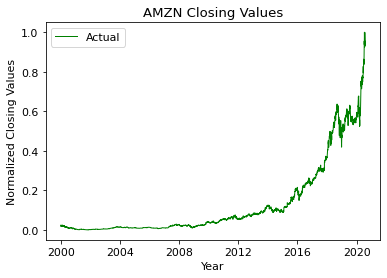

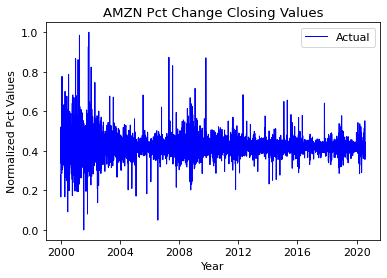

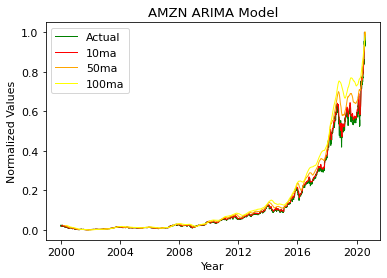

In [6]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3

#print closing value of market
plt.plot(df['Close'], color='green', label='Actual', linewidth = 1)
plt.legend(loc='best')
plt.ylabel("Normalized Closing Values")
plt.xlabel("Year")
plt.title(stock_name + " Closing Values")
plt.show()

#print percent change of closing values
plt2.plot(df['Pct Change'], color = 'blue', label = 'Actual', linewidth = 1)
plt2.legend(loc='best')
plt2.ylabel("Normalized Pct Values")
plt2.xlabel("Year")
plt2.title(stock_name + " Pct Change Closing Values")
plt2.show()

#print ARIMA model for comparison
plt3.plot(df['Close'], color = 'green', label = 'Actual', linewidth = 1)
plt3.plot(ARIMA_df['10ma'], color = 'red', label = '10ma', linewidth = 1)
plt3.plot(ARIMA_df['50ma'], color = 'orange', label = '50ma', linewidth = 1)
plt3.plot(ARIMA_df['100ma'], color = 'yellow', label = '100ma', linewidth = 1)
plt3.legend(loc='best')
plt3.ylabel("Normalized Values")
plt3.xlabel("Year")
plt3.title(stock_name + " ARIMA Model")
plt3.show()

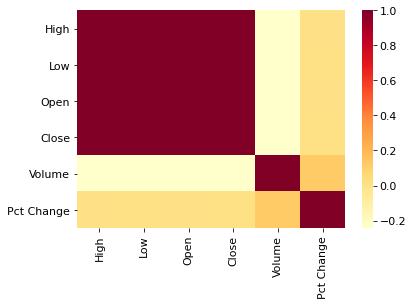


Correlation Between Features
                High       Low      Open     Close    Volume  Pct Change
High        1.000000  0.999842  0.999908  0.999900 -0.238395    0.009823
Low         0.999842  1.000000  0.999890  0.999901 -0.242386    0.010071
Open        0.999908  0.999890  1.000000  0.999801 -0.240319    0.007237
Close       0.999900  0.999901  0.999801  1.000000 -0.240310    0.012865
Volume     -0.238395 -0.242386 -0.240319 -0.240310  1.000000    0.124528
Pct Change  0.009823  0.010071  0.007237  0.012865  0.124528    1.000000


In [7]:
import seaborn as sns
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlOrRd")
plt.show()
print("\nCorrelation Between Features")
print(corr)

In [1]:
#splitting data into train and test values
def prep_model(stock, window_of_days):
    #remove stock pct change and volume since it has relatively little to no correlation with other values
    df.drop(['Pct Change'], 1, inplace = True)
    df.drop(['Volume'], 1, inplace = True)
    feature_count = len(stock.columns)
    print ("Feature count = {}".format(feature_count))
    data = stock.to_numpy() 
    sequence_length = window_of_days + 1
    result = []
    
    for i in range(len(data) - sequence_length):
        result.append(data[i: i + sequence_length]) 
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split train and test data
    print ("Amount of training data = {}".format(0.9 * result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * result.shape[0]))

    #training set
    train = result[:int(row), :] 
    x_train = train[:, :-1] #gets first set of parameters (training data) 
    y_train = train[:, -1][:,-1] #final output of training data values 
    
    #testing set
    x_test = result[int(row):, :-1] #gets last set of parameters (testing data)
    y_test = result[int(row):, -1][:,-1] #final day output

    #reshaping train and test
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], feature_count))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], feature_count))  

    return [x_train, y_train, x_test, y_test]

In [8]:
#hyperparameters and tuning
neural_net = [256, 256, 32, 1]
decay = 0.2
dropout_rate = 0.5
epochs = 200

In [9]:
def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(neural_net[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(dropout_rate))
        
    model.add(LSTM(neural_net[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(dropout_rate))
        
    model.add(Dense(neural_net[2], kernel_initializer="uniform", activation='relu'))        
    model.add(Dense(neural_net[3], kernel_initializer="uniform", activation='linear'))

    adam = keras.optimizers.Adam(decay = decay)
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
    return model

In [10]:
window_of_days = 30
X_train, y_train, X_test, y_test = prep_model(df, window_of_days)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

Feature count = 4
Amount of training data = 4626.900000000001
Amount of testing data = 514.1
X_train (4627, 30, 4)
y_train (4627,)
X_test (514, 30, 4)
y_test (514,)


In [11]:
feature_count = len(df.columns)
model = build_model([feature_count, window_of_days, 1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 256)           267264    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 800,833
Trainable params: 800,833
Non-trainable params: 0
________________________________________________

In [12]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.2,
    verbose=1)

Train on 3701 samples, validate on 926 samples
Epoch 1/300
3701/3701 [==============================] - 4s 1ms/step - loss: 0.0013 - accuracy: 2.7020e-04 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 2/300
3701/3701 [==============================] - 2s 466us/step - loss: 3.3423e-04 - accuracy: 2.7020e-04 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 3/300
3701/3701 [==============================] - 2s 459us/step - loss: 1.1288e-04 - accuracy: 2.7020e-04 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 4/300
3701/3701 [==============================] - 2s 447us/step - loss: 6.1502e-05 - accuracy: 2.7020e-04 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 5/300
3701/3701 [==============================] - 2s 449us/step - loss: 3.9092e-05 - accuracy: 2.7020e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 6/300
3701/3701 [==============================] - 2s 429us/step - loss: 3.1046e-05 - accuracy: 2.7020e-04 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch

In [13]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score\n----------\n%.5f MSE \n%.2f RMSE' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('\nTest Score\n----------\n%.5f MSE \n%.2f RMSE' % (testScore[0], math.sqrt(testScore[0])))

Train Score
----------
0.00015 MSE 
0.01 RMSE

Test Score
----------
0.00898 MSE 
0.09 RMSE


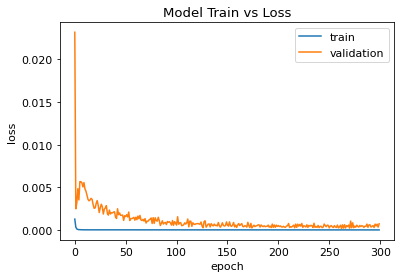

In [14]:
import matplotlib.pyplot as plt4

plt4.plot(history.history['loss'])
plt4.plot(history.history['val_loss'])
plt4.title('Model Train vs Loss')
plt4.ylabel('loss')
plt4.xlabel('epoch')
plt4.legend(['train', 'validation'], loc='best')
plt4.show()

In [15]:
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
print(p[-1])

(514, 1)
[0.7514035]


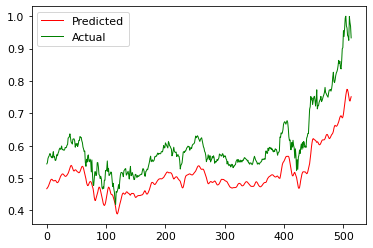

In [16]:
import matplotlib.pyplot as plt5

plt5.plot(p, color='red', label='Predicted', linewidth = 1)
plt5.plot(y_test, color='green', label='Actual', linewidth = 1)
plt5.legend(loc='best')
plt5.show()

In [17]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    
    df = df['Close'][-432:].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(stock_name, p)
newy_test = denormalize(stock_name, y_test)

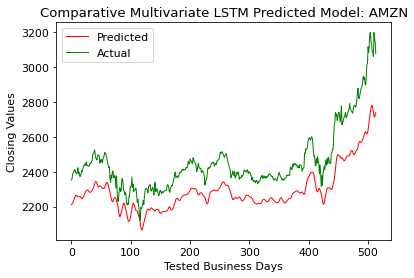

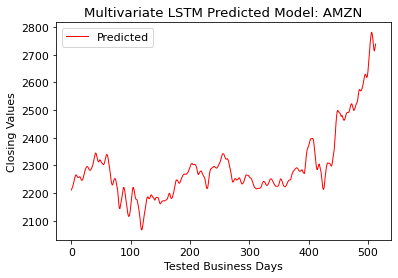

514 days


In [23]:
from numpy import savetxt

plt5.plot(newp, color='red', label='Predicted', linewidth = 1)
plt5.plot(newy_test,color='green', label='Actual', linewidth = 1)
plt5.ylabel("Closing Values")
plt5.xlabel("Tested Business Days")
plt5.title("Comparative Multivariate LSTM Predicted Model: " + stock_name)
plt5.legend(loc='best')
plt5.show()

plt5.clf()
plt5.plot(newp, color='red', label='Predicted', linewidth = 1)
plt5.ylabel("Closing Values")
plt5.xlabel("Tested Business Days")
plt5.title("Multivariate LSTM Predicted Model: " + stock_name)
plt5.legend(loc='best')
plt5.show()
print(str(len(newp)) + " days")

#save predicted values as csv
savetxt(stock_name + ' LSTM.csv', newp, delimiter=',\n')
#LSTM Model Complete. Now move onto Deep Double Q-learning!

In [20]:
#Even though the actual vs predicted are not exact, the predicted model, for the most part,
#is able to identify the direction of market trends. Thus, the Q-learning agent will work 
#to fiuring out a percent increase and relative total gains from predictive model, allowing the
#user to still make a educated guess on what he or she should do with their stocks.

In [21]:
#DQN Agent Libraries
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import warnings
warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term


In [25]:
#reading predicted data points into dataframe
df = pd.read_csv(stock_name + ' LSTM.csv', header = None)
print("Predicted Closing Values from LSTM Model")
df.head()

Predicted Closing Values from LSTM Model


,0
0,2211.167969
1,2216.050781
2,2220.947510
3,2228.029297
4,2237.291992


In [26]:
#DQN Agent Class
from collections import deque
import random

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 512, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, self.action_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost, starting_money))

In [27]:
close = df[0].values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: 1294.524902.3, cost: 0.724276, total money: 11294.524902
epoch: 20, total rewards: 1478.254150.3, cost: 0.448817, total money: 11478.254150
epoch: 30, total rewards: 1196.678711.3, cost: 0.296936, total money: 11196.678711
epoch: 40, total rewards: 1211.247070.3, cost: 0.218470, total money: 11211.247070
epoch: 50, total rewards: 1227.875244.3, cost: 0.164702, total money: 11227.875244
epoch: 60, total rewards: 961.855713.3, cost: 0.125846, total money: 10961.855713
epoch: 70, total rewards: 964.266846.3, cost: 0.108276, total money: 10964.266846
epoch: 80, total rewards: 966.894775.3, cost: 0.137737, total money: 10966.894775
epoch: 90, total rewards: 1174.909912.3, cost: 0.084827, total money: 11174.909912
epoch: 100, total rewards: 962.220215.3, cost: 0.071507, total money: 10962.220215
epoch: 110, total rewards: 1079.891357.3, c

In [28]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 2211.167969, total balance 7788.832031
day 1, sell 1 unit at price 2216.050781, investment 0.220825 %, total balance 10004.882812,
day 13: buy 1 unit at price 2256.805664, total balance 7748.077148
day 14, sell 1 unit at price 2259.020020, investment 0.098119 %, total balance 10007.097168,
day 16: buy 1 unit at price 2252.190674, total balance 7754.906494
day 18, sell 1 unit at price 2245.538330, investment -0.295372 %, total balance 10000.444824,
day 21: buy 1 unit at price 2261.756104, total balance 7738.688721
day 22: buy 1 unit at price 2270.659668, total balance 5468.029053
day 23: buy 1 unit at price 2279.901367, total balance 3188.127686
day 24, sell 1 unit at price 2286.604248, investment 1.098622 %, total balance 5474.731934,
day 25, sell 1 unit at price 2291.583740, investment 0.921498 %, total balance 7766.315674,
day 26, sell 1 unit at price 2295.465820, investment 0.682681 %, total balance 10061.781494,
day 30: buy 1 unit at price 2285.204590, to

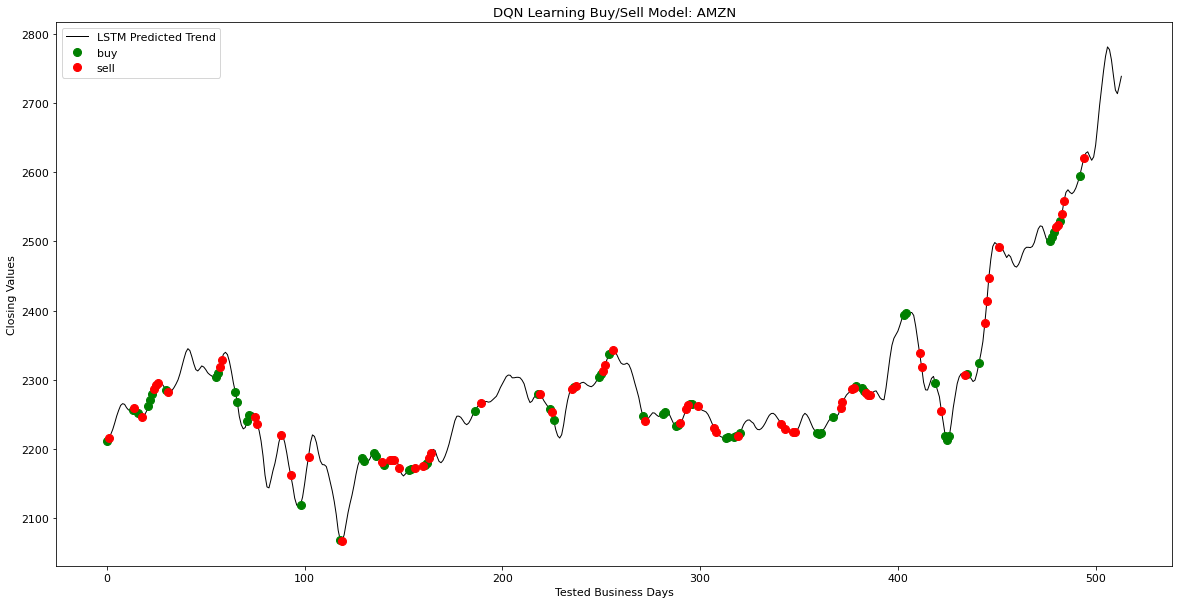

Total Profit: $957.40, Investing Percent: 9.574%


In [32]:
fig = plt.figure(figsize = (20,10))
plt.plot(close, color='black', label = "LSTM Predicted Trend", linewidth=1)
plt.plot(close, 'o', markersize=8, color='green', label = 'buy', markevery = states_buy)
plt.plot(close, 'o', markersize=8, color='red', label = 'sell', markevery = states_sell)
plt.title("DQN Learning Buy/Sell Model: " + stock_name)
plt.ylabel("Closing Values")
plt.xlabel("Tested Business Days")
plt.legend(loc = "best")
plt.show()
print('Total Profit: $%.2f, Investing Percent: %.3f%%'%(total_gains, invest))